In [3]:
from PIL import Image
import pandas as pd
import os
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
!pip install opencv-python
import cv2
from skimage.transform import rotate
from skimage.feature import canny
from skimage.measure import regionprops, label
from scipy.signal import find_peaks

In [41]:
def load_ascii(file_path):
    # Read the comma-delimited ASCII file into a DataFrame
    df = pd.read_csv(file_path, delimiter='\t',header = None)
    return df
# file_path = "/Users/YK/Desktop/Magnification_2024_6-3/mag_final_box.asc"
# df = load_ascii(file_path)
# df = df.drop(columns = df.columns[0]).drop(columns = df.columns[1025])

# print(df)
# Load the original image
original_image_path = '/Users/YK/Desktop/24_06_07_mag_grid.jpg'  # Replace with your original image file path
original_image = Image.open(original_image_path)
original_image = original_image.convert("L")  # Convert to grayscale

In [146]:
def dataframe_to_jpeg(df, output_jpeg_path):
    # Convert DataFrame to NumPy array
    data_array = df.to_numpy()
    
    # Check the shape of the array and adjust if necessary
    if len(data_array.shape) == 2:  # Grayscale image
        data_array = data_array.astype(np.uint8)  # Ensure type is uint8
        image = Image.fromarray(data_array, mode='L')
    elif len(data_array.shape) == 3 and data_array.shape[2] == 3:  # RGB image
        data_array = data_array.astype(np.uint8)  # Ensure type is uint8
        image = Image.fromarray(data_array, mode='RGB')
    else:
        raise ValueError("DataFrame shape is not compatible with grayscale or RGB images")
    
    # Save the image as a JPEG file
    image.save(output_jpeg_path)
    
dataframe_to_jpeg(df,"/Users/YK/Desktop/Magnification_2024_6-3/result.jpeg")

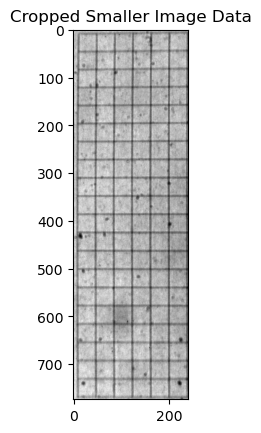

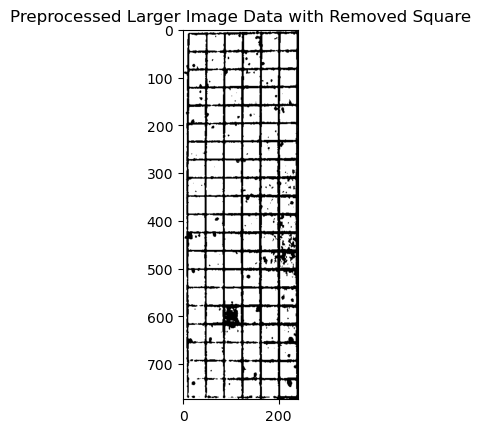

In [78]:
# crop the grid out first



# Load the cropped image
left = 30
upper = 75 
right = 271
lower = 849

# Define the offset of the cropped image in the original image
offset_x = left
offset_y = upper

# Crop the image
cropped_image = original_image.crop((left, upper, right, lower))



# Display the cropped DataFrame as an image
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Smaller Image Data')
plt.show()
# Convert the cropped image to grayscale
cropped_image_gray = cropped_image.convert("L")

# Convert the cropped image to a numpy array
cropped_image_array = np.array(cropped_image_gray)
blurred_image = cv2.GaussianBlur(cropped_image_array, (3, 3), 0)

# Apply adaptive thresholding
_, thresh_image = cv2.threshold(blurred_image, 0, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Display the preprocessed image
plt.imshow(thresh_image, cmap='gray')
plt.title('Preprocessed Larger Image Data with Removed Square')
plt.show()


cropped_width, cropped_height = cropped_image.size



(array([ 11,  49,  83, 125, 163, 202, 239]), 190)


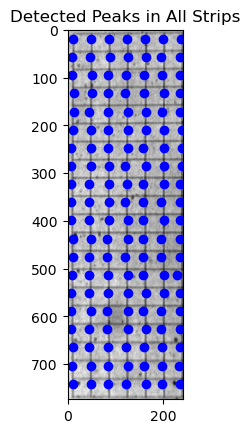

In [192]:
# Define the strip width and height for the cropped image
# cropped_width, cropped_height = cropped_image.size
strip_width = int(cropped_width / 6)
strip_height = int(cropped_height / 20)

def find_vertical_rotation_angle(strip):
    edges = canny(strip)
    labeled_img = label(edges)
    props = regionprops(labeled_img)
    vertical_angles = [prop.orientation for prop in props if np.abs(prop.orientation - np.pi/2) < np.pi/8 or np.abs(prop.orientation + np.pi/2) < np.pi/8]  # Filter vertical edges
    if vertical_angles:
        return np.mean(np.abs(vertical_angles))
    return 0.0

# Function to find the rotation angle for horizontal edges in a strip
def find_horizontal_rotation_angle(strip):
    edges = canny(strip)
    labeled_img = label(edges)
    props = regionprops(labeled_img)
    horizontal_angles = [prop.orientation for prop in props if np.abs(prop.orientation) < np.pi/8 or np.abs(prop.orientation - np.pi) < np.pi/8]  # Filter horizontal edges
    if horizontal_angles:
        return np.mean(np.abs(horizontal_angles))
    return 0.0


def vertical_strips(image_array, strip_width):
    num_strips = image_array.shape[1] // strip_width
    all_peaks_y = []
    angles_y = []
    for i in range(num_strips):
        strip = image_array[:, i * strip_width:(i + 1) * strip_width]
        rotation_angle = find_vertical_rotation_angle(strip)
        adjusted_angle = rotation_angle - np.pi/2  # Adjust the angle by subtracting pi/2
        angles_y.append(adjusted_angle)
        strip_sum = np.sum(strip, axis=1)
        width, height = image_array.shape[1], image_array.shape[0]
        distance = height / 23
        inverted_sum = -strip_sum
        h = np.mean(inverted_sum) * 0.9
        peaks, _ = find_peaks(inverted_sum,distance = distance, height = h)
        # if len(peaks) < 19:
        # # Interpolate to add missing peaks
        #     peaks = np.interp(np.linspace(0, len(peaks) - 1, 19), np.arange(len(peaks)), peaks).astype(int)
        # elif len(peaks) > 19:
        # # Select the 5 most prominent peaks
        #     peaks = peaks[np.argsort(properties['prominences'])][-19:]
        all_peaks_y.append((i * strip_width,peaks))

    return all_peaks_y,angles_y

def horizontal_strips(image_array, strip_width):
    num_strips = image_array.shape[0] // strip_width
    all_peaks_x = []
    angles_x = []
    for i in range(num_strips):
        strip = image_array[i * strip_width:(i + 1) * strip_width,:]
        rotation_angle = find_horizontal_rotation_angle(strip)
        angles_x.append(rotation_angle)
        strip_sum = np.sum(strip, axis=0)
        width, height = image_array.shape[1], image_array.shape[0]
        distance = width / 9
        inverted_sum = -strip_sum
        h = np.mean(inverted_sum) * 0.7
        peaks, _ = find_peaks(inverted_sum,distance = distance, height = h)
        all_peaks_x.append((peaks, i * strip_width))

    return all_peaks_x,angles_x

# Function to calculate magnification for each strip
def calculate_magnification2(peaks, delta_z, w, angle):
    if len(peaks) > 1:
        pixel_locations = (peaks[:-1] + peaks[1:]) / 2
        M_P = delta_z / (((peaks[1:] - peaks[:-1]) * w) / np.cos(angle))
        return pixel_locations, M_P
    return [], []

peaks_y, angles_y = vertical_strips(thresh_image, strip_width)
peaks_x, angles_x = horizontal_strips(thresh_image, strip_height)


# manually add missing points using cheat function

def cheat(strip_index,new_peak):
    peak, loc = peaks_x[strip_index]
    peaks_x[strip_index] = (np.sort(np.append(peak, new_peak)), loc)
cheat(3,235)
cheat(4,235)
cheat(9,45)
cheat(10,125)
cheat(13,83)

def cheat2(strip_index, old_peak, new_peak):
    _, loc = peaks_x[strip_index]
    peaks = peaks_x[strip_index][0]
    peaks = np.array([new_peak if peak == old_peak else peak for peak in peaks])
    peaks_x[strip_index] = (np.sort(peaks), loc)
cheat2(7,65, 49)
cheat(7,86)
cheat2(4, 207, 197)
cheat2(8, 230, 235)
cheat2(9, 226, 235)
cheat2(14, 207, 202)
cheat2(10, 206, 202)
cheat2(5, 196, 202)
print(peaks_x[5])

plt.imshow(cropped_image, cmap='gray')

for peaks,y in peaks_x:
    plt.scatter(peaks,[y + strip_height // 2] * len(peaks), color='blue')

# for x, peaks in peaks_y:
#     plt.scatter([x + strip_width // 2] * len(peaks), peaks, color='red')


plt.title("Detected Peaks in All Strips")
plt.show()


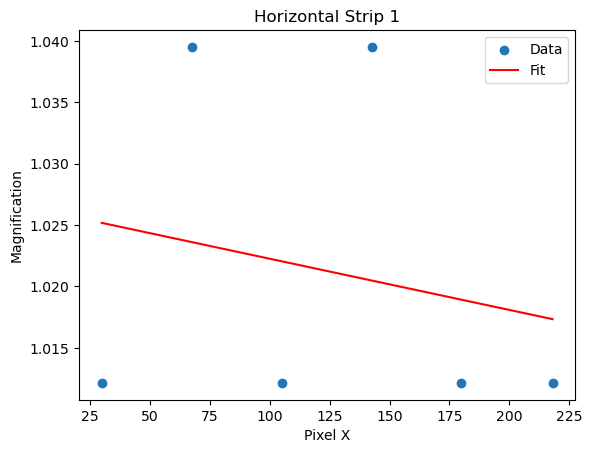

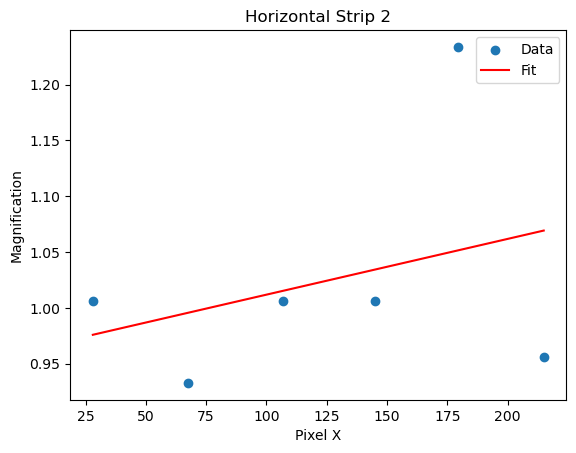

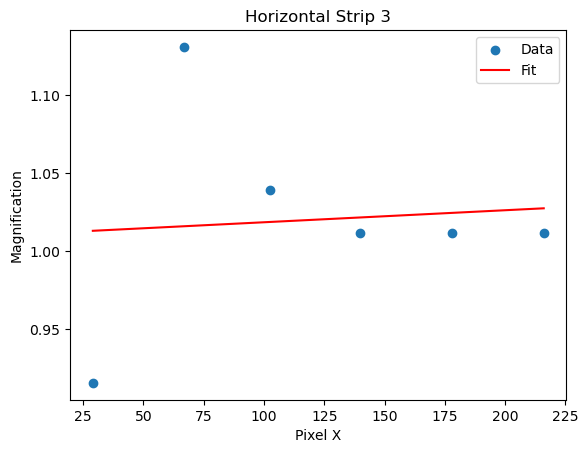

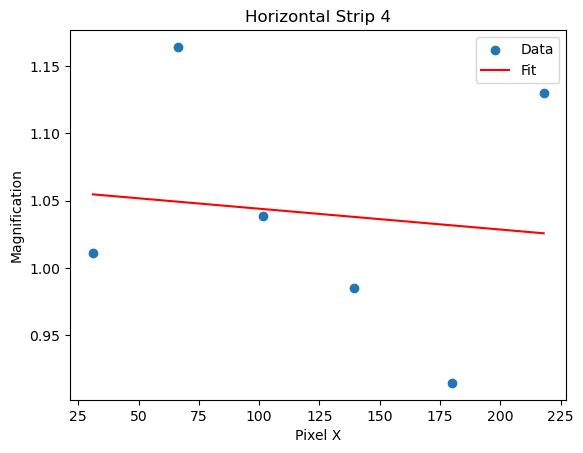

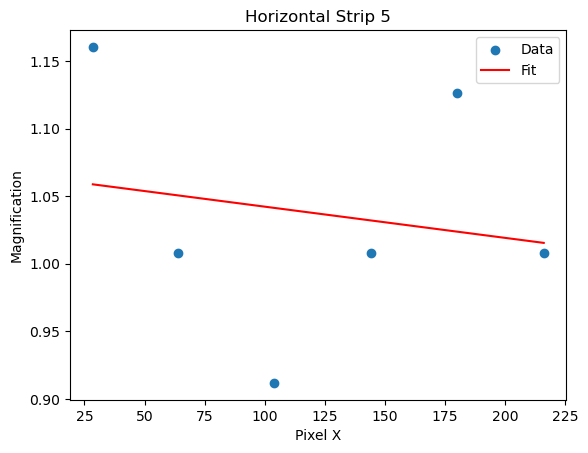

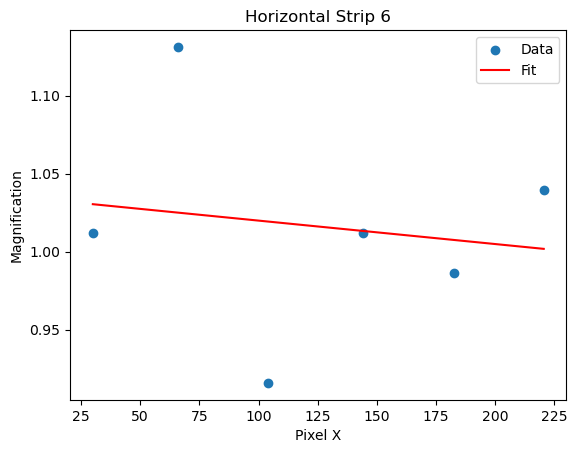

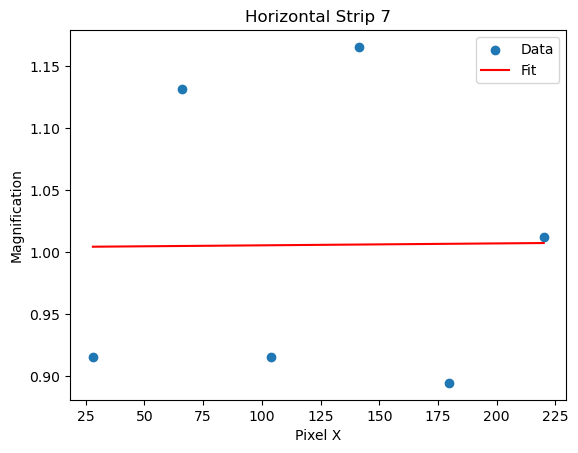

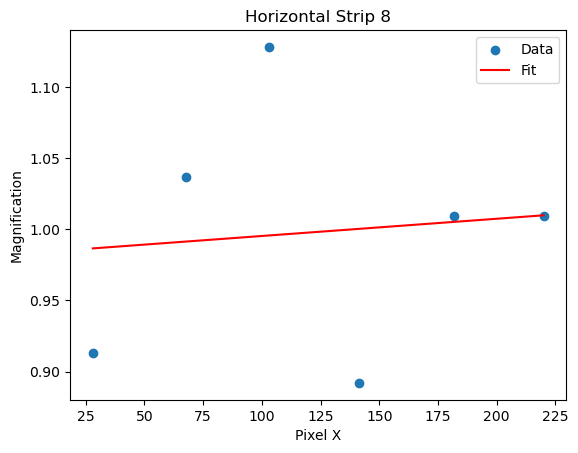

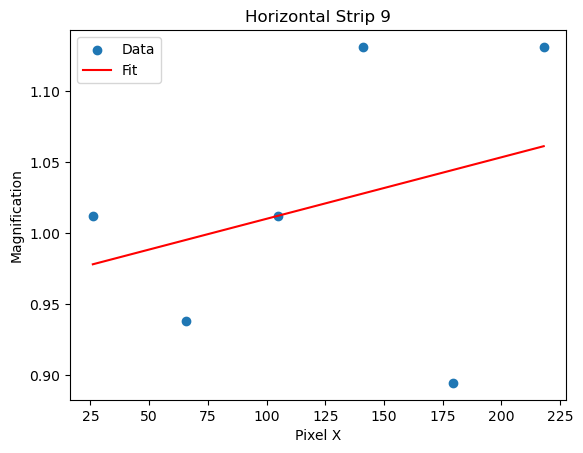

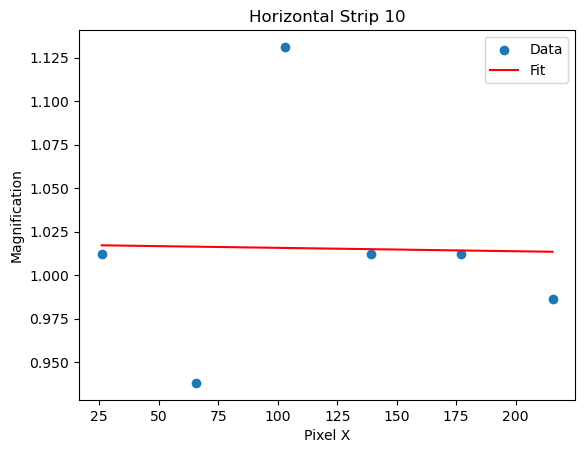

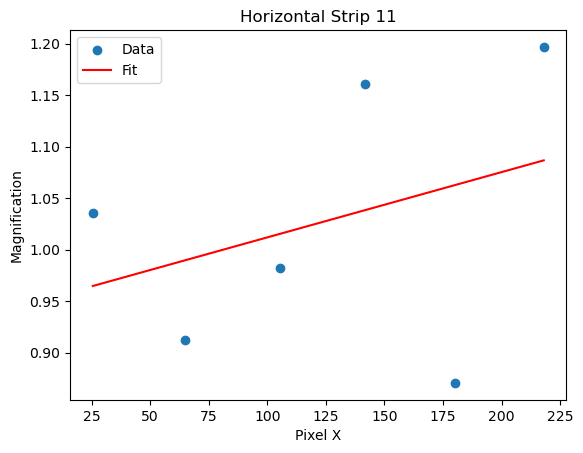

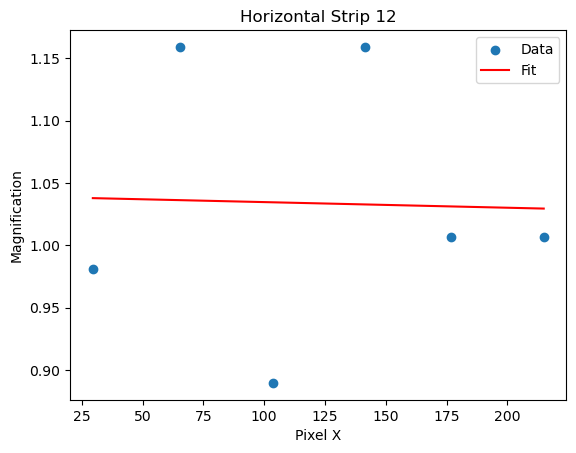

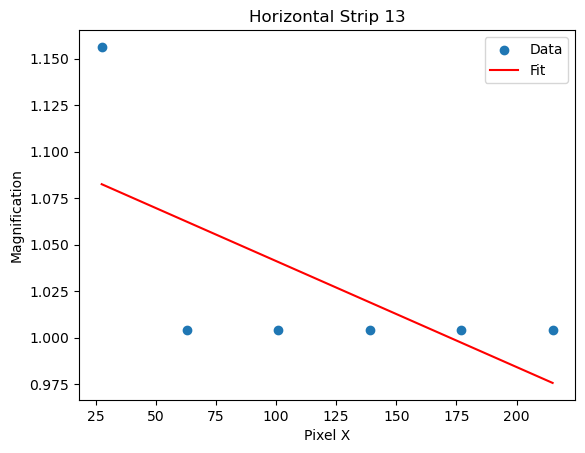

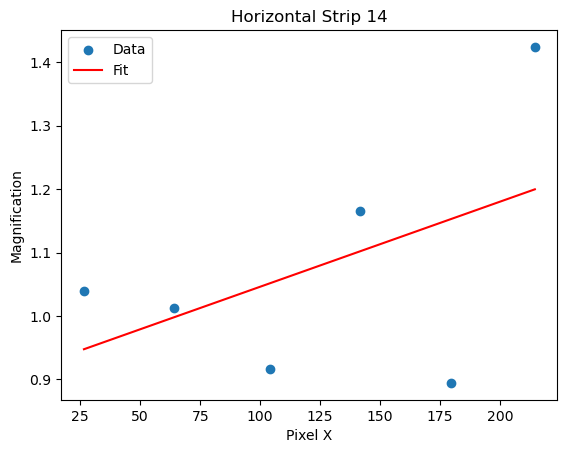

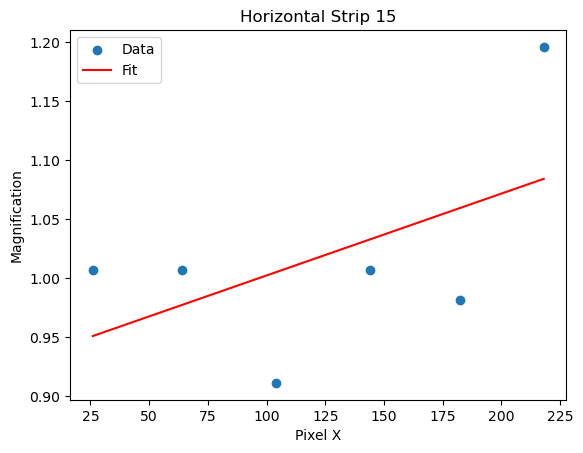

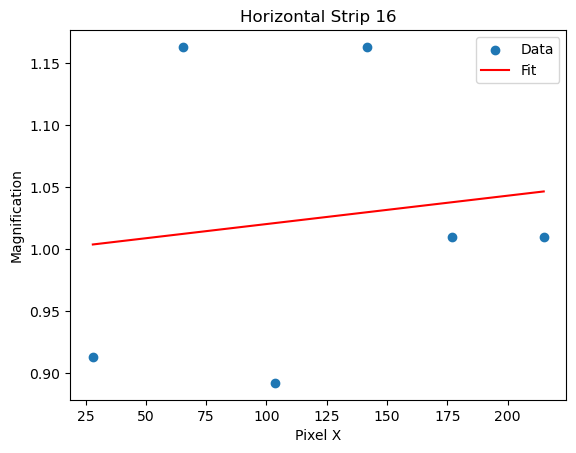

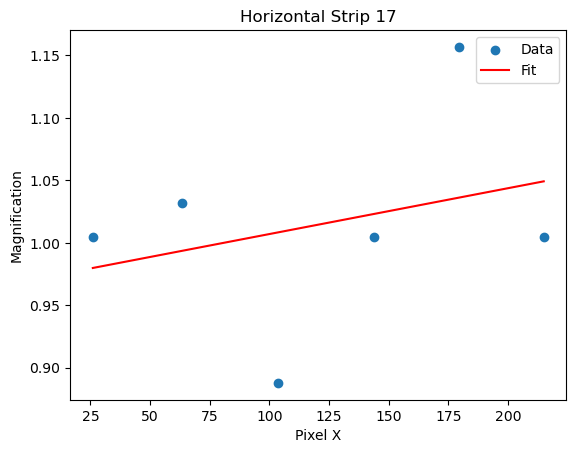

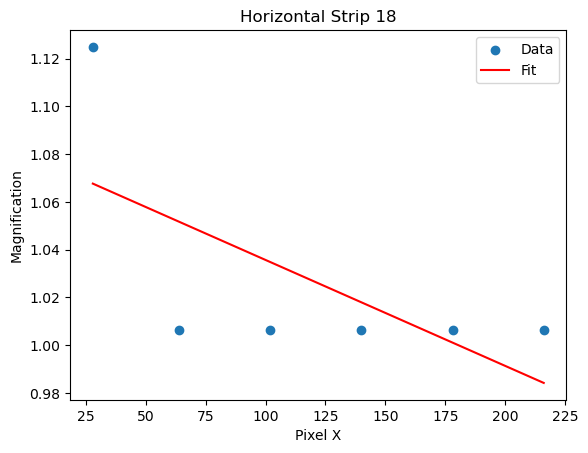

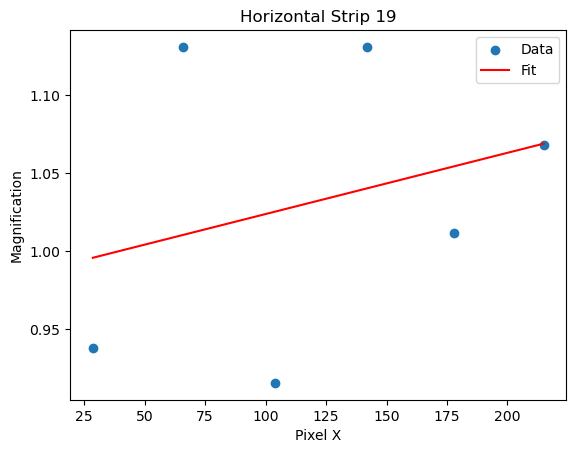

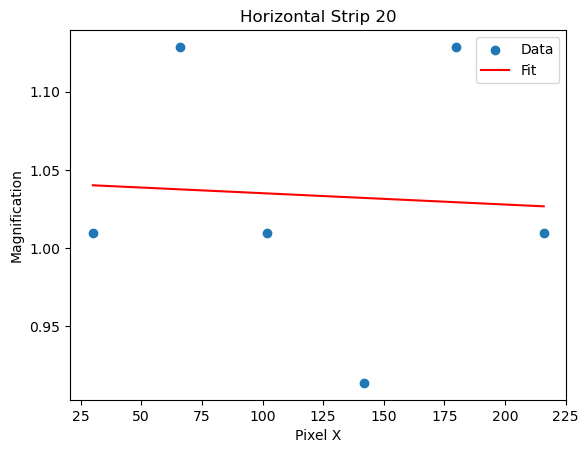

In [193]:
# Parameters for magnification calculation
delta_z = 500  # in micrometers
w = 13  # in micrometers

# Collect all data points for x and y directions separately
all_pixel_locations_x = []
all_magnifications_x = []
all_pixel_locations_y = []
all_magnifications_y = []

def linear_model(X, a, b):
    return a * X + b

# Lists to store linear fit results
fits_x = []
fits_y = []

for idx, (peaks,y) in enumerate(peaks_x):
    angle = angles_x[idx]
    pixel_locations_x, M_Px = calculate_magnification2(peaks, delta_z, w, angle)
    if len(pixel_locations_x) > 0:
        all_pixel_locations_x.extend(pixel_locations_x + offset_x)
        all_magnifications_x.extend(M_Px)
        popt_x, _ = curve_fit(linear_model, pixel_locations_x, M_Px)
        fits_x.append((popt_x, pixel_locations_x, M_Px))
         # Plot the fit result
        plt.figure()
        plt.scatter(pixel_locations_x, M_Px, label='Data')
        plt.plot(pixel_locations_x, linear_model(pixel_locations_x, *popt_x), color='red', label='Fit')
        plt.title(f'Horizontal Strip {idx + 1}')
        plt.xlabel('Pixel X')
        plt.ylabel('Magnification')
        plt.legend()
        plt.show()





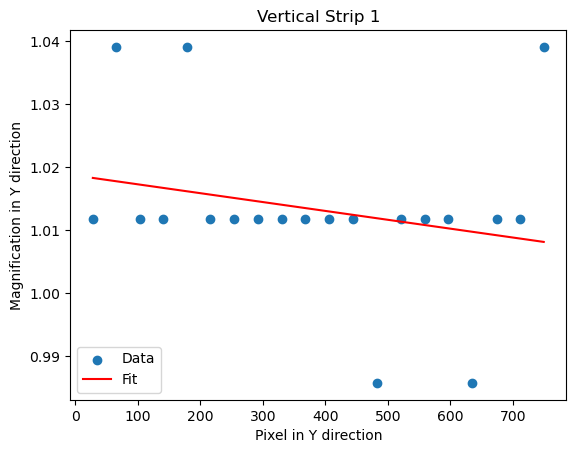

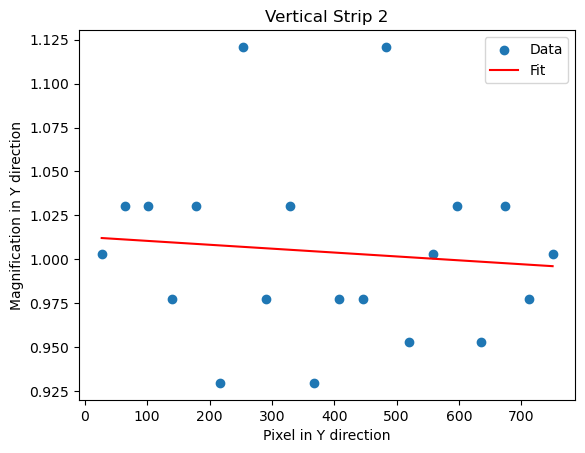

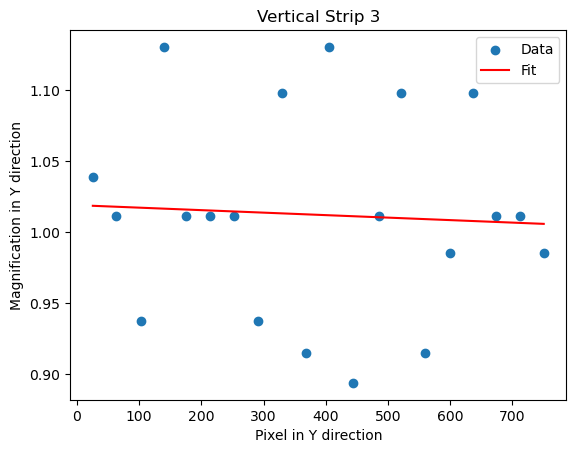

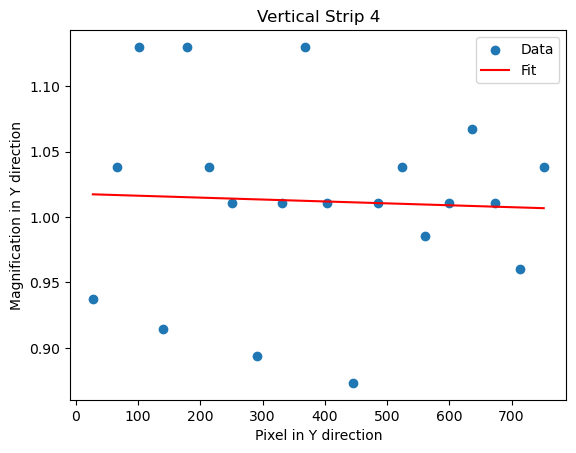

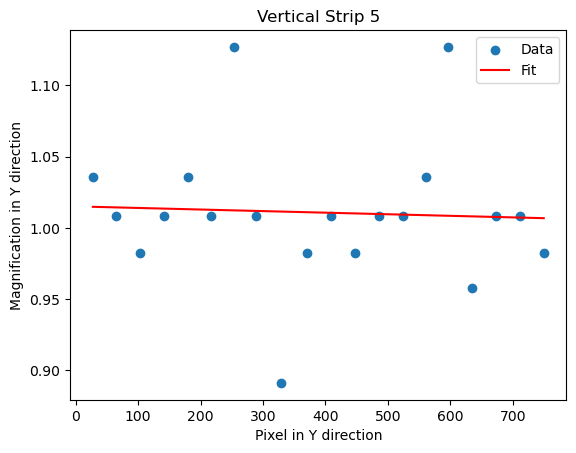

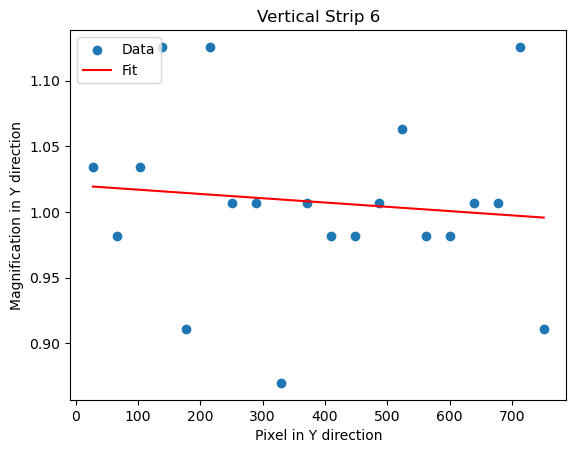

In [195]:
# Calculate magnification for each vertical strip and collect data points
for idx, (x, peaks) in enumerate(peaks_y):
    angle = angles_y[idx]
    pixel_locations_y, M_Py = calculate_magnification2(peaks, delta_z, w, angle)
    if len(pixel_locations_y) > 0:
        all_pixel_locations_y.extend(pixel_locations_y + offset_y)
        all_magnifications_y.extend(M_Py)
        popt_y, _ = curve_fit(linear_model, pixel_locations_y, M_Py)
        fits_y.append((popt_y, pixel_locations_y, M_Py))
        plt.figure()
        plt.scatter(pixel_locations_y, M_Py, label='Data')
        plt.plot(pixel_locations_y, linear_model(pixel_locations_y, *popt_y), color='red', label='Fit')
        plt.title(f'Vertical Strip {idx + 1}')
        plt.xlabel('Pixel in Y direction')
        plt.ylabel('Magnification in Y direction')
        plt.legend()
        plt.show()
        

In [196]:
flat_x = np.array(all_pixel_locations_x)
flat_y = np.array(all_pixel_locations_y)
flat_magnification_x = np.array(all_magnifications_x)
flat_magnification_y = np.array(all_magnifications_y)

# Define the linear model for fitting
def linear_model(X, a, b):
    return a * X + b

# Perform the linear fit for magnification vs pixel locations in x and y directions
if len(flat_x) == len(flat_magnification_x) and len(flat_x) > 0:
    popt_x, pcov_x = curve_fit(linear_model, flat_x, flat_magnification_x)
else:
    raise ValueError("Mismatch in length of flat_x and flat_magnification_x or they are empty!")

if len(flat_y) == len(flat_magnification_y) and len(flat_y) > 0:
    popt_y, pcov_y = curve_fit(linear_model, flat_y, flat_magnification_y)
else:
    raise ValueError("Mismatch in length of flat_y and flat_magnification_y or they are empty!")

# Generate magnification values for all pixel locations using the linear fits
pixel_x = np.arange(1, 1025)
pixel_y = np.arange(1, 1025)
predicted_magnification_x = linear_model(pixel_x, *popt_x)
predicted_magnification_y = linear_model(pixel_y, *popt_y)

# Save the results to a CSV file
df_results = pd.DataFrame({
    'pixel_x': pixel_x,
    'magnification_x': predicted_magnification_x,
    'pixel_y': pixel_y,
    'magnification_y': predicted_magnification_y
})
df_results.to_csv('/Users/YK/Desktop/magnification_fits.csv', index=False)
